In [22]:
import warnings
warnings.filterwarnings("ignore")
import re
import pandas as pd
import numpy as np
import tensorflow as tf
import math
import hanlp
import pickle
import collections
import keras
import pydot
import pydotplus
from pydotplus import graphviz
import time
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score


In [23]:
def process_raw_data(file_path,label_cols,text_fea_cols,categorical_fea_cols,numeric_fea_cols,):
    df_raw = pd.read_csv(file_path, header=0, error_bad_lines=False, delimiter='\t', engine='python')    
    df_raw.fillna(value="",inplace=True)    
    df_no_user=df_raw.iloc[:,1:]
    
    '''for easy debug'''
    #df_no_user=df_no_user.head(300)

    labels=df_no_user.iloc[:,label_cols]
    text_fea=df_no_user.iloc[:,text_fea_cols]
    categorical_fea=df_no_user.iloc[:,categorical_fea_cols]
    numeric_fea=df_no_user.iloc[:,numeric_fea_cols]
       
    return df_no_user,labels,text_fea,categorical_fea,numeric_fea
     

In [24]:
def process_categorical_fea(df):
    df_encode=df.apply(LabelEncoder().fit_transform)
    return df_encode

In [25]:
def process_numeric_fea(df):
    x = df.values
    '''Attention vs min_max_scale,使用min_max_scale会导致准确率大幅下降，因为min-max映射到[0-1],而standard不是'''
    std_scaler = preprocessing.StandardScaler() 
    x_scaled = std_scaler.fit_transform(x)
    return pd.DataFrame(x_scaled,columns = df.columns.values)

In [26]:
def load_stop_words(filename):
    with open(filename,'r',encoding="utf-8") as f:
        stopwords_raw = f.readlines()
    return set([stop.strip() for stop in stopwords_raw])
    

def remove_stop_words(text,stopwords):
    text_without_stopwords = []
    for tokens in text:
        tokens_new=[]
        for t in tokens:
            if t not in stopwords:
                tokens_new.append(t)
        text_without_stopwords.append(tokens_new)
    return text_without_stopwords

def text_regex(text,
               regex='[a-zA-Z0-9’!"#$%&\'()*（）：；＋－+,-./:;<=>?@，。?★、…【】《》？“”‘’！[\\]^_`{|}~\s]+'):
    text_re=[]
    text_re=[re.sub(regex,"",t) for t in text]
    return text_re

def text_seg(text):   
    
    tok = hanlp.load(hanlp.pretrained.tok.COARSE_ELECTRA_SMALL_ZH)
    text_seg=tok(text)
    stopwords=load_stop_words("../config/stopwords.txt")
    #print("stopwords=",stopwords)
    text_seg=remove_stop_words(text_seg,stopwords)
    return text_seg

def get_tokenizer(path,text=None,num_words=5000): 
    
    try:
        with open(path, 'rb') as handle:
            tokenizer = pickle.load(handle)
            return tokenizer
    except:
        tokenizer=Tokenizer(num_words=num_words,oov_token='<OOV>',char_level=False)
        tokenizer.fit_on_texts(text)
        return tokenizer

def save_tokenizer(tokenizer,path):
    with open(path, 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
        
def process_text_fea(df,num_words=5000,token_path=None,max_len=50,text_matrix=False,matrix_mode='count'):
    if len(df.columns.values)!=1:
        raise Exception("df should has only one text type columns!")
    text=df.values.reshape(df.shape[0]).tolist()
    text=text_regex(text)
    text=text_seg(text)
    text_token=[]
    for text_ent in text:
        token_str=""
        for token in text_ent:
            token_str+=token+" "
        text_token.append(token_str.strip())
    
    tokenizer=get_tokenizer(path=token_path,text=text_token,num_words=num_words)
    save_tokenizer(tokenizer,token_path)
    if text_matrix:
        text_sequence=tokenizer.texts_to_sequences(texts=text_token)
        text_sequence=tokenizer.sequences_to_matrix(sequences=text_sequence,mode=matrix_mode)
    else:
        text_sequence=tokenizer.texts_to_sequences(texts=text_token)
        text_sequence=pad_sequences(sequences=text_sequence,padding="post",maxlen=max_len,truncating='pre')
    
    text_sequence=np.asarray(text_sequence).tolist()
    
    return pd.DataFrame({df.columns.values[0]:text_sequence})


In [27]:
def get_label_and_feature(train_data,test_data,cost_label_col,recharge_label_col,text_fea_cols,categorical_fea_cols,numeric_fea_cols):
    
    train_cost_label=train_data[:,cost_label_col]
    train_recharge_label=train_data[:,recharge_label_col]
    train_text_fea=train_data[:,text_fea_cols]
    train_cate_fea=train_data[:,categorical_fea_cols] 
    train_numeric_fea=train_data[:,numeric_fea_cols]
    
    test_cost_label=test_data[:,cost_label_col]
    test_recharge_label=test_data[:,recharge_label_col]
    test_text_fea=test_data[:,text_fea_cols]
    test_cate_fea=test_data[:,categorical_fea_cols]
    test_numeric_fea=test_data[:,numeric_fea_cols]
    
    ##此处加上这个是为了解决：Failed to convert a NumPy array to a Tensor (Unsupported object type int).
    train_cost_label=np.asarray(train_cost_label).astype('int32')
    train_recharge_label=np.asarray(train_recharge_label).astype('int32')
    train_cate_fea=np.asarray(train_cate_fea).astype('int32')
    train_numeric_fea=np.asarray(train_numeric_fea).astype('float32') ##float not int !!
    
    '''
    单独处理train_text_fea，因为里面的元素是list，没法直接用上述方式转成int32
    '''
    train_text_fea=np.reshape(train_text_fea,(train_text_fea.shape[0],))
    train_text_fea_convert=[]
    for item in train_text_fea:
        train_text_fea_convert.append(np.asarray(item))
    train_text_fea=np.asarray(train_text_fea_convert).astype('int32')
           
    test_cost_label=np.asarray(test_cost_label).astype('int32')
    test_recharge_label=np.asarray(test_recharge_label).astype('int32')
    test_cate_fea=np.asarray(test_cate_fea).astype('int32')
    test_numeric_fea=np.asarray(test_numeric_fea).astype('float32') ##float not int !!
    
    '''
    单独处理test_text_fea，因为里面的元素是list，没法直接用上述方式转成int32
    '''
    test_text_fea=np.reshape(test_text_fea,(test_text_fea.shape[0],))
    test_text_fea_convert=[]
    for item in test_text_fea:
        test_text_fea_convert.append(np.asarray(item))
    test_text_fea=np.asarray(test_text_fea_convert).astype('int32')
    
    return train_cost_label,train_recharge_label,train_text_fea,train_cate_fea,train_numeric_fea,test_cost_label,test_recharge_label,test_text_fea,test_cate_fea,test_numeric_fea

    
    

In [28]:
def split_train_test_data(df,original=True,all_label_cols=None,label_col=None,label_values=None,label_counts=None,repeat_noise_ratio=0.95,sample_noise_ratio=0.95):
    
    print('-'*10+"label counts in all data"+'-'*10)   
    for lc in all_label_cols:
        print('label: ',lc)
        print(df_data.iloc[:,lc].value_counts())
          
    
    data=df.values  
    train_data,test_data=train_test_split(data,test_size=0.1)   
    
    if original==False:
        if len(label_values)!=len(label_counts):
            raise ValueError("list label_values'size isn't equal to list label_counts!")
        if len(np.unique(train_data[:,label_col]))!=len(label_counts):
            raise ValueError("df data dosen't has all label type!")
        
        print('-'*10+"label counts in train data BEFORE sample|repeat|noise"+'-'*10) 
        for lc in all_label_cols:
            print('label: ',lc)
            print(collections.Counter(train_data[:,lc]))
            
        train_data_dict={}
        for i in label_values:
            lv=label_values[i]
            lc=label_counts[i]
            #td=train_data[np.in1d(train_data[:, label_col], lv)]
            td=train_data[np.equal(train_data[:, label_col], lv)]
            td_other=train_data[np.not_equal(train_data[:, label_col], lv)]
            if td.shape[0]>=lc:
                print("label value=",lv," more than need! need=",lc," exist=",td.shape[0])
                noise_counts=math.ceil(lc*(1-sample_noise_ratio))
                noise_idxs=np.random.randint(td_other.shape[0],size=min(noise_counts,td_other.shape[0]))
                noise_td=td_other[noise_idxs,:]
                print("noise data counts=",noise_td.shape[0])
                noise_td[:,label_col]=lv
                               
                sample_counts=lc-noise_td.shape[0]
                sample_idxs=np.random.randint(td.shape[0],size=sample_counts)
                sample_td=td[sample_idxs,:]
                print("sample data counts=",sample_td.shape[0])
               
                merge_td=np.concatenate((sample_td,noise_td),axis=0)
                train_data_dict[lv]=np.asarray(merge_td)
            elif td.shape[0]<lc:
                print("label value=",lv," less than need! need=",lc," exist=",td.shape[0])
                lack_counts=lc-td.shape[0]
                print("lack_counts=",lack_counts)
                noise_counts=math.ceil(lack_counts*(1-repeat_noise_ratio))
                noise_idxs=np.random.randint(td_other.shape[0],size=noise_counts)
                noise_td=td_other[noise_idxs,:]
                print("noise data counts=",noise_td.shape[0])
                noise_td[:,label_col]=lv
                
                repeat_counts=lc-noise_counts
                repeat_times=math.ceil(repeat_counts/td.shape[0])
                repeat_td=np.repeat(td,repeat_times+2,axis=0)
                
                sample_idxs=np.random.randint(repeat_td.shape[0],size=repeat_counts)
                repeat_td=repeat_td[sample_idxs,:]
                print("repeat data counts=",repeat_td.shape[0])
                
                merge_td=np.concatenate((repeat_td,noise_td),axis=0)
                train_data_dict[lv]=np.asarray(merge_td)
                
        train_data=np.concatenate(list(train_data_dict.values()),axis=0)
        print('-'*10+"label counts in train data AFTER sample|repeat|noise"+'-'*10) 
        for lc in all_label_cols:
            print('label: ',lc)
            print(collections.Counter(train_data[:,lc]))
    
    print("train_data.shape=",train_data.shape)
    print('-'*10+"splited data counts"+'-'*10)   
    print('train:',train_data.shape)
    print('test:',test_data.shape)
    
    return train_data,test_data


In [29]:
def text_block_of_model(max_sequence_length,num_words,text_embed_size,lstm_embed_size):
    inputs=tf.keras.layers.Input(shape=(max_sequence_length,),dtype=tf.int32,name='text_inputs')
    print("text embed's input size=",num_words)
    embed_outputs=tf.keras.layers.Embedding(input_dim=num_words, output_dim=text_embed_size, input_length=max_sequence_length,embeddings_initializer=tf.initializers.random_normal)(inputs)
    #lstm_outputs=Bidirectional(LSTM(lstm_embed_size,activation="relu",dropout=0.2,return_sequences=True))(embed_outputs)
    lstm_outputs=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_embed_size,activation="relu",dropout=0.2,return_sequences=False))(embed_outputs)
    '''add batchnorm,to normlize the output for the same scale with numeric'''
    norm_outputs=tf.keras.layers.BatchNormalization()(lstm_outputs)
    return inputs,norm_outputs


In [30]:
def cate_block_of_model(cate_num_sizes,cate_embed_sizes):
    inputs=[]
    outputs=[]
    if len(cate_num_sizes)!=len(cate_embed_sizes):
        raise ValueError("cate size!= embed size!")
    for i in range(len(cate_num_sizes)):
        inpt = tf.keras.layers.Input(shape=(1,),dtype=tf.int32,name='cate_inputs_'+str(i))
        inputs.append(inpt)
        print("cate "+str(i)+" size:cate_num_sizes=",str(cate_num_sizes[i])+" ")
        embed = tf.keras.layers.Embedding(cate_num_sizes[i],cate_embed_sizes[i], trainable=True,embeddings_initializer=tf.initializers.random_normal)(inpt)
        embed_rehsaped =tf.keras.layers.Reshape(target_shape=(cate_embed_sizes[i],))(embed)
        outputs.append(embed_rehsaped)  
    concate_outputs=tf.keras.layers.concatenate(outputs)
    '''add batchnorm,to normlize the output for the same scale with numeric'''
    norm_outputs=tf.keras.layers.BatchNormalization()(concate_outputs)
    return inputs,norm_outputs


In [31]:
def numeric_block_of_model(input_size,dense_size):
    inputs=tf.keras.layers.Input(shape=(input_size,),dtype=tf.float32,name='numeric_inputs')
    dense_outputs=tf.keras.layers.Dense(dense_size, activation='relu')(inputs)
    norm_outputs=tf.keras.layers.BatchNormalization()(dense_outputs)
    return inputs,norm_outputs


In [32]:
def create_multi_task_learning_model(cate_num_sizes,cate_embed_sizes,
               text_max_sequence_length=50,text_num_words=5000,text_embed_size=100,text_lstm_embed_size=20,
               numeric_input_size=200,numeric_dense_size=50
              ):
    
    cate_inputs,cate_outputs=cate_block_of_model(cate_num_sizes,cate_embed_sizes)
    text_inputs,text_outputs=text_block_of_model(max_sequence_length=text_max_sequence_length,num_words=text_num_words,text_embed_size=text_embed_size,lstm_embed_size=text_lstm_embed_size)
    numeric_inputs,numeric_outputs=numeric_block_of_model(input_size=numeric_input_size,dense_size=numeric_dense_size)
    
    outputs=tf.keras.layers.concatenate([cate_outputs,text_outputs,numeric_outputs])
    outputs=tf.keras.layers.BatchNormalization()(outputs)
    outputs=tf.keras.layers.Dense(60, activation='relu')(outputs)
    outputs=tf.keras.layers.BatchNormalization()(outputs)
    
    outputs_cost=tf.keras.layers.Dense(20, activation='relu')(outputs)
    outputs_cost=tf.keras.layers.BatchNormalization()(outputs_cost)
    outputs_cost=tf.keras.layers.Dense(3, activation='softmax',name='outputs_cost')(outputs_cost)
    
    outputs_recharge=tf.keras.layers.Dense(20, activation='relu')(outputs)
    outputs_recharge=tf.keras.layers.BatchNormalization()(outputs_recharge)
    outputs_recharge=tf.keras.layers.Dense(3, activation='softmax',name='outputs_recharge')(outputs_recharge)
    
    model = Model(inputs=cate_inputs+[text_inputs,numeric_inputs], outputs=[outputs_cost,outputs_recharge])
    
    #model.summary()
    #tf.keras.utils.plot_model(model, to_file='../model/main_model.png',show_shapes=True,show_dtype=True,show_layer_activations=True)
    
    return model
        

In [33]:
def compile_multitask_model(model, gamma):
        
    model.compile(optimizer='adam',
                  loss={'outputs_cost': 'sparse_categorical_crossentropy', 
                        'outputs_recharge': 'sparse_categorical_crossentropy'},
                  loss_weights={'outputs_cost': gamma, 
                                'outputs_recharge': 1 - gamma}, 
                  metrics=['accuracy'])
        
    return model

In [34]:
def fit_batch(model):  
    start = time.time()
    history =model.fit(x={'cate_inputs_0': train_cate_fea[:,0],
                                'cate_inputs_1': train_cate_fea[:,1],
                                'cate_inputs_2': train_cate_fea[:,2],
                                'text_inputs': train_text_fea,
                                'numeric_inputs':train_numeric_fea},
                             y={'outputs_cost': train_cost_label,
                                'outputs_recharge': train_recharge_label},
                             validation_split=0.1,
                             epochs=train_epochs, batch_size=32, verbose=1)
    print(f'Training time: {time.time() - start}\n')
    return history


In [35]:
def plot_multitask_accuracies(training_history):
    
    plt.plot(range(len(history.history['outputs_cost_accuracy'])), history.history['outputs_cost_accuracy'], c='r', label='Cost')
    plt.plot(range(len(history.history['outputs_recharge_accuracy'])), history.history['outputs_recharge_accuracy'], c='b', label='Recharge')

    plt.plot(range(len(history.history['val_outputs_cost_accuracy'])), history.history['val_outputs_cost_accuracy'], c='r',linestyle='dashed', marker='o', label='Val-Cost')
    plt.plot(range(len(history.history['val_outputs_recharge_accuracy'])), history.history['val_outputs_recharge_accuracy'], c='b', linestyle='dashed', marker='o', label='Val-Recharge')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


In [36]:
def evaluate_score(y_true,y_pred_prob):
    pred_label=np.asarray([np.argmax(v) for v in y_pred_prob])
    print('accuracy: %.3f' % accuracy_score(y_true, pred_label))
    print('ovr macro auc: %.3f' % roc_auc_score(y_true, y_pred_prob,multi_class='ovo',average='macro')) #注意这里是prob
    print('ovo macro auc: %.3f' % roc_auc_score(y_true, y_pred_prob, multi_class='ovr',average='macro')) #注意这里是prob
    print('ovr weighted auc: %.3f' % roc_auc_score(y_true, y_pred_prob,multi_class='ovo',average='weighted')) #注意这里是prob
    print('ovo weighted auc: %.3f' % roc_auc_score(y_true, y_pred_prob, multi_class='ovr',average='weighted')) #注意这里是prob
    print('micro precision: %.3f' % precision_score(y_true, pred_label,average='micro'))
    print('macro precision: %.3f' % precision_score(y_true, pred_label,average='macro'))
    print('weighted precision: %.3f' % precision_score(y_true, pred_label,average='weighted'))
    print('micro recall: %.3f' % recall_score(y_true, pred_label,average='micro'))
    print('macro recall: %.3f' % recall_score(y_true, pred_label,average='macro'))
    print('weighted recall: %.3f' % recall_score(y_true, pred_label,average='weighted'))

In [37]:

print('*'*27+" Multi-Task-Model Begin Running "+'**'*27+"\n\n")

print('-'*40+" load data begin "+'-'*40)
label_cols=[0,1]
cost_label_col=0
recharge_label_col=1
text_fea_cols=[2]
categorical_fea_cols=[3,4,5]
numeric_fea_cols=list(range(6,262))
recharge_label_values=[0,1,2]

'''--tuning params--'''
recharge_label_counts=[10000,20000,100000]
is_raw=False
gamma_values=[0.5]
text_matrix=False
train_epochs=20
repeat_noise_ratio=1
sample_noise_ratio=1
num_words=3000
token_path="../tokenizer/tokenizer_2.1.pickle" #Attention,别跟别的模型乱了词表，所以此处要specific
max_sequence_len=50
'''--tuning params--'''

data_file="../data/train_data_nlp_and_number_and_category_feature_multi_label_small.txt"

numeric_input_size=len(numeric_fea_cols)

df_no_user,labels,text_fea,categorical_fea,numeric_fea=process_raw_data(
    file_path=data_file,
    label_cols=label_cols,
    text_fea_cols=text_fea_cols,
    categorical_fea_cols=categorical_fea_cols,
    numeric_fea_cols=numeric_fea_cols
    )

print("df_no_user.shape=",df_no_user.shape)
print("labels.shape=",labels.shape)
print("text_fea.shape=",text_fea.shape)
print("categorical_fea.shape=",categorical_fea.shape)
print("numeric_fea.shape=",numeric_fea.shape)
print(df_no_user.head(1))
print('-'*40+" load data end "+'-'*40)

*************************** Multi-Task-Model Begin Running ******************************************************


---------------------------------------- load data begin ----------------------------------------
df_no_user.shape= (145994, 262)
labels.shape= (145994, 2)
text_fea.shape= (145994, 1)
categorical_fea.shape= (145994, 3)
numeric_fea.shape= (145994, 256)
   c_label  r_label                                    problem_content  \
0        2        2  采购员客服发布招聘信息刷新优化#电话联系 设置采购 客服精品刷新 效果不好 建议客户多发帖#...   

   main_belong_loc1  main_belong_cate2 main_city_hierarchy  free_money_avg_1d  \
0              7578               3112                  二线                0.0   

   free_money_avg_3d  free_money_avg_7d  free_money_avg_14d  ...  \
0           0.002022           0.006067            0.013146  ...   

   pc_login_counts_7d  pc_login_counts_14d  pc_login_counts_30d  \
0                   7                   14                   30   

   pc_login_counts_60d  m_login_counts_1d  m_log

In [38]:
print('-'*40+" process feature begin "+'-'*40)
#df_text_token=process_text_fea(df=text_fea,token_path="../tokenizer/tokenizer.pickle",text_matrix=True) 

df_text_token=process_text_fea(df=text_fea,num_words=num_words,token_path=token_path,max_len=max_sequence_len) 
df_categorical_fea_enc=process_categorical_fea(categorical_fea)
df_numeric_fea_scale=process_numeric_fea(numeric_fea)

df_data=pd.concat([labels,df_text_token,df_categorical_fea_enc,df_numeric_fea_scale],axis=1)
print(df_data.shape)
print(df_data.head(1))

if is_raw:
    train_data,test_data=split_train_test_data(df_data,all_label_cols=label_cols,original=True)
else:
    train_data,test_data=split_train_test_data(df_data,all_label_cols=label_cols,original=False,
                                               label_col=recharge_label_col,label_values=recharge_label_values,label_counts=recharge_label_counts,
                                               repeat_noise_ratio=repeat_noise_ratio,sample_noise_ratio=sample_noise_ratio)


print('-'*40+" process feature end "+'-'*40)

---------------------------------------- process feature begin ----------------------------------------


(145994, 262)
   c_label  r_label                                    problem_content  \
0        2        2  [2287, 91, 84, 3, 32, 17, 143, 19, 5, 18, 1330...   

   main_belong_loc1  main_belong_cate2  main_city_hierarchy  \
0               439                108                    2   

   free_money_avg_1d  free_money_avg_3d  free_money_avg_7d  \
0                0.0          -0.185336          -0.297657   

   free_money_avg_14d  ...  pc_login_counts_7d  pc_login_counts_14d  \
0           -0.372249  ...            1.525443             1.592377   

   pc_login_counts_30d  pc_login_counts_60d  m_login_counts_1d  \
0             1.652389             1.406186          -0.007852   

   m_login_counts_3d  m_login_counts_7d  m_login_counts_14d  \
0          -0.010219          -0.013579           -0.014876   

   m_login_counts_30d  m_login_counts_60d  
0           -0.015785           -0.020121  

[1 rows x 262 columns]
----------label counts in all data----------
label:  0
2    107995
1  

In [39]:
print('-'*40+" process label and feature begin "+'-'*40)
train_cost_label,train_recharge_label,train_text_fea,train_cate_fea,train_numeric_fea,test_cost_label,test_recharge_label,test_text_fea,test_cate_fea,test_numeric_fea=get_label_and_feature(
    train_data,test_data,
    cost_label_col,recharge_label_col,
    text_fea_cols,categorical_fea_cols,numeric_fea_cols)

print("train_cost_label.shape=",train_cost_label.shape)
print("train_recharge_label.shape=",train_recharge_label.shape)
print("train_text_fea.shape=",train_text_fea.shape)
print("train_cate_fea.shape=",train_cate_fea.shape)
print("train_numeric_fea.shape=",train_numeric_fea.shape)

print("test_cost_label.shape=",test_cost_label.shape)
print("test_recharge_label.shape=",test_recharge_label.shape)
print("test_text_fea.shape=",test_text_fea.shape)
print("test_cate_fea.shape=",test_cate_fea.shape)
print("test_numeric_fea.shape=",test_numeric_fea.shape)

print('-'*40+" process label and feature end "+'-'*40)


---------------------------------------- process label and feature begin ----------------------------------------
train_cost_label.shape= (130000,)
train_recharge_label.shape= (130000,)
train_text_fea.shape= (130000, 50)
train_cate_fea.shape= (130000, 3)
train_numeric_fea.shape= (130000, 256)
test_cost_label.shape= (14600,)
test_recharge_label.shape= (14600,)
test_text_fea.shape= (14600, 50)
test_cate_fea.shape= (14600, 3)
test_numeric_fea.shape= (14600, 256)
---------------------------------------- process label and feature end ----------------------------------------


In [40]:

print('-'*40+" train model begin "+'-'*40)

cate_num_sizes=[]
cate_embed_sizes=[]
for c in categorical_fea_cols:
    cs=train_data[:,c].max()+1 #attention +1 begin because from zero!!!    
    cate_num_sizes.append(cs)
    cate_embed_sizes.append(math.ceil(cs/20)+2)

trained_models=list()
training_histories=list()
predict_results=list()
for i in range(len(gamma_values)):
    print(f"train model for gamma={gamma_values[i]}")
    model=create_multi_task_learning_model(cate_num_sizes=cate_num_sizes,cate_embed_sizes=cate_embed_sizes,
                                       text_max_sequence_length=max_sequence_len,text_num_words=num_words,text_embed_size=100,text_lstm_embed_size=20,
                                       numeric_input_size=numeric_input_size,numeric_dense_size=50)
    compile_multitask_model(model,gamma_values[i])
    history=fit_batch(model)
    
    
    pred_result=model.predict(x={'cate_inputs_0': test_cate_fea[:,0],
                                    'cate_inputs_1': test_cate_fea[:,1],
                                    'cate_inputs_2': test_cate_fea[:,2],
                                    'text_inputs': test_text_fea,
                                    'numeric_inputs':test_numeric_fea}
                                 ,verbose=1,use_multiprocessing=True)
    trained_models.append(model)
    training_histories.append(history)
    predict_results.append(pred_result)
    
print('-'*40+" train model end "+'-'*40)

      

---------------------------------------- train model begin ----------------------------------------
train model for gamma=0.5
cate 0 size:cate_num_sizes= 655 
cate 1 size:cate_num_sizes= 148 
cate 2 size:cate_num_sizes= 9 
text embed's input size= 3000
Epoch 1/20
3657/3657 [==============================] - 126s 33ms/step - loss: 0.5319 - outputs_cost_loss: 0.6656 - outputs_recharge_loss: 0.3983 - outputs_cost_accuracy: 0.7322 - outputs_recharge_accuracy: 0.8458 - val_loss: 0.3510 - val_outputs_cost_loss: 0.5770 - val_outputs_recharge_loss: 0.1250 - val_outputs_cost_accuracy: 0.7811 - val_outputs_recharge_accuracy: 0.9607
Epoch 2/20
3657/3657 [==============================] - 122s 33ms/step - loss: 0.3703 - outputs_cost_loss: 0.5416 - outputs_recharge_loss: 0.1991 - outputs_cost_accuracy: 0.7916 - outputs_recharge_accuracy: 0.9221 - val_loss: 0.3312 - val_outputs_cost_loss: 0.5619 - val_outputs_recharge_loss: 0.1004 - val_outputs_cost_accuracy: 0.7834 - val_outputs_recharge_accuracy: 

---------------------------------------- plot and evaluate begin ----------------------------------------
plot for gamma=0.5


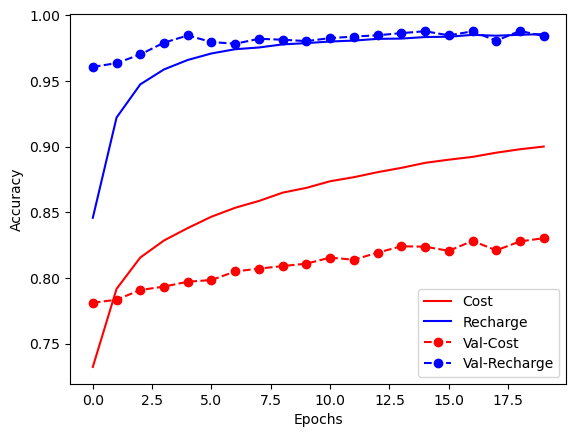

-----------消耗模型评估分值: ---------
accuracy: 0.747
ovr macro auc: 0.724
ovo macro auc: 0.757
ovr weighted auc: 0.756
ovo weighted auc: 0.767
micro precision: 0.747
macro precision: 0.561
weighted precision: 0.717
micro recall: 0.747
macro recall: 0.509
weighted recall: 0.747
-----------充值模型评估分值: ---------
accuracy: 0.963
ovr macro auc: 0.745
ovo macro auc: 0.783
ovr weighted auc: 0.778
ovo weighted auc: 0.786
micro precision: 0.963
macro precision: 0.412
weighted precision: 0.974
micro recall: 0.963
macro recall: 0.471
weighted recall: 0.963
---------------------------------------- plot and evaluate end ----------------------------------------


In [43]:
print('-'*40+" plot and evaluate begin "+'-'*40)
for i in range(len(gamma_values)):
    
    print(f"plot for gamma={gamma_values[i]}")
    plot_multitask_accuracies(training_histories[i])

    pred_result=np.asarray(predict_results[i])
    predict_prob_cost=pred_result[0]
    predict_prob_recharge=pred_result[1]
    print("-----------消耗模型评估分值: ---------")
    evaluate_score(test_cost_label,predict_prob_cost)
    print("-----------充值模型评估分值: ---------")
    evaluate_score(test_recharge_label,predict_prob_recharge)

print('-'*40+" plot and evaluate end "+'-'*40)
